* This notebook was made to look at salinity and current field difference between original and weakslip case within three days (Oct8-10, 2014)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import datetime
import scipy.io as sio
import os
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from salishsea_tools import nc_tools, viz_tools, tidetools, stormtools, bathy_tools
from __future__ import division

In [2]:
ferry_stations = {'Tsawwassen': {'lat': 49.0084,'lon': -123.1281},
                  'Duke': {'lat': 49.1632,'lon': -123.8909}}

In [3]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]
grid10 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea10.nc')

In [4]:
## load data
codar = sio.loadmat('/ocean/jieliu/research/meopar/salinity_comparison/SoG_radar_totals.mat')
t_codar = codar['mtime']
lat_codar = codar['glat']
lon_codar = codar['glon']
u = codar['u']
v = codar['v']

In [5]:
## initialize the start_time and determine run_time
start_time = datetime.datetime(2014, 10, 8,0)
run_time = datetime.datetime(2014, 10, 8, 0)

In [6]:
from datetime import timedelta
def python_time(run_time):
    run_upper = run_time.replace(minute = 30)
    if run_time.hour != 0:
        run_lower = run_time.replace(hour = run_time.hour-1, minute = 30)
    else:
        run_lower = run_time.replace(day = run_time.day -1,hour =23, minute=30)
    for i,tt  in enumerate(np.arange(0,len(t_codar))):
        matlab_datenum = np.float(t_codar[i])
        python_datetime = datetime.datetime.fromordinal(int(matlab_datenum))\
        + timedelta(days=matlab_datenum%1) - timedelta(days = 366)
        if (python_datetime > run_lower)&(python_datetime < run_upper):
            return python_datetime, i

In [7]:
#subset
ist=1
ien=398
jst=1
jen=898
x=np.arange(ist,ien)
y=np.arange(jst,jen)
st=3
cmin, cmax, dels = -1, 1, 0.2

In [8]:
def seek_ferry_time(ax,run_time, value_flag=True):
    """if value_flag =true, it returns only minimum ferry
       salinity value and location, else, it returns plot,
       if not within ferry running time, return None"""
    
    directory = '/ocean/jieliu/research/meopar/autodataupdate/ferrydata/';
    base = 'SBE19'
    if run_time.hour ==0 or run_time.hour ==3 or run_time.hour ==5:
        path = os.path.join(directory,'{}'.format(base)+\
                run_time.replace(day = run_time.day -1).strftime('%Y%m%d')+'.mat')
    elif run_time.hour == 12 or run_time.hour ==14 or run_time.hour ==16 or \
        run_time.hour ==19 or run_time.hour ==21:
        path = os.path.join(directory,'{}'.format(base)+\
                run_time.replace(day = run_time.day ).strftime('%Y%m%d')+'.mat')
    else:
        path = []
    if path!= []:
        saline = sio.loadmat(path)
        dataa = saline['ferryData']['data'][0,0]
        time=dataa['matlabtime'][0,0]
        lonn=dataa['Longitude'][0,0]
        latt=dataa['Latitude'][0,0]
        salinity=dataa['Practical_Salinity'][0,0]
        
        a=len(time)
        lon1=np.zeros([a,1])
        lat1=np.zeros([a,1])
        salinity1=np.zeros([a,1])
        if run_time.hour ==3 or run_time.hour ==5 or run_time.hour ==12 or run_time.hour ==19:
            run_lower = run_time.replace( minute = 15)#!!more convenient than day,miniute..
            run_upper = run_time.replace(hour= run_time.hour + 2, minute=45)
        else:
            run_lower = run_time.replace( minute = 45)
            if run_time.hour ==16 or run_time.hour ==0:
                run_upper = run_time.replace(hour= run_time.hour + 3, minute=15)
            elif run_time.hour == 21:
                 run_upper = run_time.replace(day = run_time.day +1, hour=0, minute=45)    
            else:
                run_upper = run_time.replace(hour=run_time.hour + 2, minute=45)
        for i in np.arange(0,a):
            matlab_datenum = np.float(time[i])
            python_datetime = datetime.datetime.fromordinal(int(matlab_datenum))\
            + timedelta(days=matlab_datenum%1) - timedelta(days = 366)

            if (python_datetime >= run_lower) &(python_datetime <= run_upper):
                lon1[i]=lonn[i]
                lat1[i]=latt[i]
                salinity1[i]=salinity[i]
        mask=lon1[:,0]!=0
        lon1_2_4=lon1[mask]
        lat1_2_4=lat1[mask]
        salinity1_2_4=salinity1[mask]
        
        if value_flag:## just return salinity and location
            return lon1_2_4, lat1_2_4, salinity1_2_4
        else:
            ##plot    
            cm = plt.cm.get_cmap('spectral',12)
            sc = ax.scatter(lon1_2_4, lat1_2_4, c = salinity1_2_4,\
               edgecolor ='', vmin =10,vmax = 30, s =30, cmap = cm)
            cbar = plt.colorbar(sc, ax=ax)
            plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)
            cbar.set_label('Practical Salinity', fontsize = 20)
            return sc
    else: 
        return None

In [9]:
def plot_route_min(ax, run_time):
    """This function was made to plot ferry route on modelled map
        as well as location of minimum salinity value"""
    ## plot location of minimum salinity value    
    if run_time.hour ==0 or run_time.hour ==3 or run_time.hour ==5 or\
    run_time.hour == 12 or run_time.hour ==14 or run_time.hour ==16 or \
    run_time.hour ==19 or run_time.hour ==21:
        lon1_2_4, lat1_2_4,salinity1_2_4 = seek_ferry_time(ax, run_time, value_flag = True)
        ## find minimum salinity value and location(for all points,
        ##rather than every five points)
        min_sal = np.nanmin(salinity1_2_4)
        ind = np.nanargmin(salinity1_2_4)        
        min_loca = lon1_2_4[ind]
        min_lat = lat1_2_4[ind]
        ##plot route
        route_plot = ax.plot(lon1_2_4, lat1_2_4, 'k',linewidth = 5)
        cm = plt.cm.get_cmap('spectral',20)
        ##plot minimum salinity location
        point_plot = ax.scatter(min_loca,min_lat,c= min_sal,marker='*', s = 30**2,\
                                vmin =10,vmax = 30,cmap = cm)
        return route_plot,point_plot
    else:
        return None, None

In [10]:
directory = '/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/'
path = os.path.join(directory, 'SalishSea_1h_20141008_20141010_grid_T.nc')
grid_T = nc.Dataset(path,'r')
bases = ['/data/jieliu/MEOPAR/river-treatment/','/data/jieliu/MEOPAR/river-treatment/',\
             '/data/jieliu/MEOPAR/parameters/','/data/jieliu/MEOPAR/parameters/']
runs = ['oct8_101e061e05','oct8_10jetty1e0605','oct8_101e0605shlat0.2','oct8_10jettyshlat0.2']
u_m = {};v_m = {};S_m = {};U_m ={};V_m={};baths = [grid6,grid10, grid6,grid10]
for base,run,grid in zip(bases,runs,baths):
    path = os.path.join(base, '{}/SalishSea_1h_20141008_20141010_grid_U.nc'.format(run))
    grid_U = nc.Dataset(path,'r')
    t = (run_time.day-8)*24+run_time.hour
    u_m[run] =grid_U.variables['vozocrtx'][t, 0,jst-1:jen,ist-1:ien]
    path = os.path.join(base, '{}/SalishSea_1h_20141008_20141010_grid_V.nc'.format(run))
    grid_V = nc.Dataset(path,'r')
    v_m[run] =grid_V.variables['vomecrty'][t, 0,jst-1:jen,ist-1:ien]
    path = os.path.join(base, '{}/SalishSea_1h_20141008_20141010_grid_T.nc'.format(run))
    grid_T = nc.Dataset(path,'r')
    S_m[run] = grid_T.variables['vosaline'][t, 1, jst:jen,ist:ien]
    lon = grid.variables['nav_lon'][jst:jen,ist:ien]
    lat = grid.variables['nav_lat'][jst:jen,ist:ien]
    ##unstagger u v
    U_m[run],V_m[run] = viz_tools.unstagger(u_m[run],v_m[run])
    #rotate
    theta = np.pi*29/180
    U_m[run] = U_m[run]*np.cos(theta) - V_m[run]*np.sin(theta)
    V_m[run] = U_m[run]*np.sin(theta) +V_m[run]*np.cos(theta)
    ##mask
    U_m[run]=np.ma.masked_values(U_m[run],0)
    V_m[run]=np.ma.masked_values(V_m[run],0)   

In [11]:
def plot_whole(run_time):
    fig = plt.figure(figsize=(38,26))
    gs = gridspec.GridSpec(3, 3,width_ratios=[1, 1,1], height_ratios=[1, 1,1])  
    gs.update(hspace=0.15, wspace=0.1)
    ##plot codar quiver
    ax = fig.add_subplot(gs[0,0])
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'OrangeRed')
    ax.plot(-123-np.array([18.2,13.7,12])/60.,49+np.array([6.4,8,7.6])/60.,'-k',lw=2,color='Indigo')
    p, ind = python_time(run_time)
    #quiver = axs[0].quiver(lon, lat,u[:,:,ind], v[:,:,ind],pivot='mid',width=0.005, color='black')
    ## to average adjent hours, say average of 16:00 and 17:00 as 16:30
    quiver = ax.quiver(lon_codar, lat_codar,np.nanmean(np.array([u[:,:,ind],u[:,:,ind+1]])/100, axis = 0),\
                    np.nanmean(np.array([v[:,:,ind],v[:,:,ind+1]])/100,axis =0),\
                           pivot='mid', scale = 15,width=0.005, color='black')
    ax.quiverkey(quiver,-123.1,49.35, 1, '1 m/s',
                    coordinates='data', color='black', labelcolor='black',
                fontproperties = {'size': '15'})
    bbox_args = dict(boxstyle='square', facecolor='white', alpha=0.7)
    stations=['Tsawwassen','Duke']
    for stn in stations:
        ax.plot(ferry_stations[stn]['lon'], ferry_stations[stn]['lat'], marker='D', \
                    color='SpringGreen',\
                 markersize=20, markeredgewidth=2)
    ax.annotate ('Tsawwassen',(ferry_stations['Tsawwassen']['lon']-0.07 ,\
    ferry_stations['Tsawwassen']['lat'] + 0.02), fontsize=15, color='black', bbox=bbox_args )
    ax.annotate ('Duke Point',(ferry_stations['Duke']['lon'] -0.11 ,\
    ferry_stations['Duke']['lat']-0.05 ),fontsize=20, color='black', bbox=bbox_args )
    ## add ferry salinity if it has
    sc = seek_ferry_time(ax, run_time,value_flag = False)
    
    lonax = [-124.0,-123]
    latax= [48.9,49.4]   
    ax.set_xlim(lonax)
    ax.set_ylim(latax)
    plt.setp(ax.get_xticklabels(), fontsize=20)
    plt.setp(ax.get_yticklabels(), fontsize=20)
    ax.set_xlabel('Longitude',fontsize=20)
    ax.set_ylabel('Latitude',fontsize=20)
    ax.set_title('codar surface currents on '+run_time.replace(minute = 30).strftime\
                     ('%d-%b-%Y %H:%M'), fontsize = 25)
    ## plot ssh at PA
    ax = fig.add_subplot(gs[0,1])
    directory = '/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/'
    path = os.path.join(directory, 'SalishSea_1h_20141008_20141010_grid_T.nc')
    grid_T = nc.Dataset(path,'r')
    ssh =grid_T.variables['sossheig']
    timesteps = grid_T.variables['time_counter'][:]
    t_t = nc_tools.timestamp(grid_T, np.arange(len(timesteps)))
    for ind in range(len(t_t)):
        t_t[ind] = t_t[ind].datetime
    tt = np.array(t_t)   
    start_time = datetime.datetime(2014,10,8,0,0)
    hrs = (run_time.day-start_time.day)*24+ run_time.hour - start_time.hour  
    ax.plot(tt,ssh[:,466,329],'-k')
    ax.plot(tt[hrs],ssh[hrs, 466, 329],'o',color='tomato',markersize=9)
    plt.setp(ax.get_xticklabels(), fontsize=20)
    plt.setp(ax.get_yticklabels(), fontsize=20)
    ax.grid('on')
    ax.set_ylabel('Water level (m)', fontsize = 20)
    ax.set_title('Modelled water level at Point Atkinson on '+ \
                run_time.replace(minute = 30).strftime('%d-%b-%Y %H:%M'),fontsize = 20)
    ## determine the phase of M2 consititute at PA(utc time zone)
    omega = 360/12.25; deviation = omega*(tt[hrs].hour+ 0.5) - 31;
    if deviation>=360:
        deviation = deviation - 360;
    print ('M2 tidal phase at PA is: ' + str(deviation) +' degree')
    ## plot modelled surface currents
        #max_mod, max_data = maxmin_currents_mod_data(lon,lat,np.nanmin(lon_codar),\
            #np.nanmax(lon_codar),np.nanmin(lat_codar),np.nanmax(lat_codar), U_m[run], V_m[run]) 
    ax3 = fig.add_subplot(gs[1,0]);ax4 = fig.add_subplot(gs[1,1])
    ax5 = fig.add_subplot(gs[2,0]);ax6 = fig.add_subplot(gs[2,1])
    ax_line1=[ax3,ax4];ax_line2=[ax5,ax6]; U1=[U_m['oct8_101e061e05'],U_m['oct8_101e0605shlat0.2']];
    U2=[U_m['oct8_10jetty1e0605'],U_m['oct8_10jettyshlat0.2']];
    V1=[V_m['oct8_101e061e05'],V_m['oct8_101e0605shlat0.2']];
    V2=[V_m['oct8_10jetty1e0605'],V_m['oct8_10jettyshlat0.2']];
    S1=[S_m['oct8_101e061e05'],S_m['oct8_101e0605shlat0.2']];runn1 = [runs[0], runs[2]];
    S2=[S_m['oct8_10jetty1e0605'],S_m['oct8_10jettyshlat0.2']]; runn2 = [runs[1], runs[3]];
    for ax_1, ax_2, U1_m, U2_m, V1_m, V2_m,S1_m,S2_m,run_1,\
    run_2,in zip(ax_line1,ax_line2,U1,U2,V1,V2,S1,S2,runn1,runn2):
        cm = plt.cm.get_cmap('spectral',12)
        mesh1=ax_1.pcolormesh(lon,lat,S1_m,vmin =10,vmax = 30,cmap=cm)        
        quiver1 = ax_1.quiver(lon[::st,::st], lat[::st,::st],U1_m[ ::st, ::st], V1_m[::st,::st],\
                           pivot='mid',scale=15,width=0.005, color='black' )
        ax_1.quiverkey(quiver1,-123.1,49.25, 1, '1 m/s',coordinates='data', color='black',\
                       labelcolor='black',fontproperties = {'size': '20'})
        viz_tools.plot_land_mask(ax_1,grid6,coords='map',xslice=x,yslice=y,color='burlywood')
        ## add minimum salinity plot if available
        route_plot,point_plot = plot_route_min(ax_1, run_time)
        cbar = plt.colorbar(mesh1, ax=ax_1)
        cbar.set_label('Practical Salinity', fontsize = 20)
        plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20) 
        ax_1.set_title(run_time.replace(minute = 30).strftime('%d-%b-%Y %H:%M')+\
        ' Surface currents and salinity of {}'.format(run_1), fontsize = 20)  
        ax_1.set_xlim([-124.,-123]);ax_1.set_ylim([48.9,49.4])
        mesh2=ax_2.pcolormesh(lon,lat,S2_m,vmin =10,vmax = 30,cmap=cm)        
        quiver2 = ax_2.quiver(lon[::st,::st], lat[::st,::st],U2_m[ ::st, ::st], V2_m[::st,::st],\
                           pivot='mid',scale=15,width=0.005, color='black' )
        ax_2.quiverkey(quiver,-123.1,49.25, 1, '1 m/s',coordinates='data', color='black',\
                       labelcolor='black',fontproperties = {'size': '20'})
        viz_tools.plot_land_mask(ax_2,grid10,coords='map',xslice=x,yslice=y,color='burlywood')
        route_plot,point_plot = plot_route_min(ax_2, run_time)     
        ax_2.set_xlim([-124.,-123]); ax_2.set_ylim([48.9,49.4])
        cbar = plt.colorbar(mesh2, ax=ax_2)
        cbar.set_label('Practical Salinity', fontsize = 20)
        plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20) 
        ax_2.set_title(run_time.replace(minute = 30).strftime('%d-%b-%Y %H:%M')+\
        ' Surface currents and salinity of {}'.format(run_2), fontsize = 20)  
    ## plot the difference    
    ax7 = fig.add_subplot(gs[1,2]);ax8 = fig.add_subplot(gs[2,2])
    sal_diff1 = S_m[runs[0]] - S_m[runs[2]];sal_diff2 = S_m[runs[1]] - S_m[runs[3]];
    U_diff1 = U_m[runs[0]] - U_m[runs[2]];U_diff2 = U_m[runs[1]] - U_m[runs[3]];
    V_diff1 = V_m[runs[0]] - V_m[runs[2]];V_diff2 = V_m[runs[1]] - V_m[runs[3]];
    mesh=ax7.pcolormesh(lon,lat,sal_diff1,cmap='RdBu_r',vmin=cmin, vmax=cmax)
    quiver = ax7.quiver(lon[::st,::st], lat[::st,::st],U_diff1[ ::st, ::st], V_diff1[::st,::st],\
                           pivot='mid',scale=15,width=0.005, color='black' )
    ax7.quiverkey(quiver,-123.1,49.25, 1, '1 m/s',coordinates='data', color='black', labelcolor='black',
                    fontproperties = {'size': '20'})
    viz_tools.plot_land_mask(ax7,grid6,coords='map',xslice=x,yslice=y,color='burlywood')
    cbar1 = plt.colorbar(mesh, ax=ax7)
    cbar1.set_label(' Salinity difference',fontsize = 20)
    ax7.set_title('difference between rn_shlat = 0.5 and 0.2 on\
    '+run_time.replace(minute = 30).strftime('%d-%b-%Y %H:%M'),fontsize = 20)
    mesh=ax8.pcolormesh(lon,lat,sal_diff2,cmap='RdBu_r',vmin=cmin, vmax=cmax)
    quiver = ax8.quiver(lon[::st,::st], lat[::st,::st],U_diff2[ ::st, ::st], V_diff2[::st,::st],\
                           pivot='mid',scale=15,width=0.005, color='black' )
    ax8.quiverkey(quiver,-123.1,49.25, 1, '1 m/s',
                        coordinates='data', color='black', labelcolor='black',fontproperties = {'size': '20'})
    viz_tools.plot_land_mask(ax8,grid10,coords='map',xslice=x,yslice=y,color='burlywood')
    cbar2 = plt.colorbar(mesh, ax=ax8)
    cbar2.set_label(' Salinity difference',fontsize = 20)
    ax8.set_title('difference between rn_shlat = 0.5 and 0.2 on\
    '+run_time.replace(minute = 30).strftime('%d-%b-%Y %H:%M'),fontsize = 20)
    axss = [ax3,ax4,ax5,ax6,ax7,ax8]
    for ax in axss:
        ax.set_xlim([-124.,-123])
        ax.set_ylim([48.9,49.4])
        plt.setp(plt.getp(cbar1.ax.axes, 'yticklabels'), color='k', fontsize = 20) 
        plt.setp(plt.getp(cbar2.ax.axes, 'yticklabels'), color='k', fontsize = 20) 
        ax.set_xticks([-124,-123.8,-123.6, -123.4, -123.2,-123])
        ax.set_xticklabels([-124,-123.8,-123.6, -123.4, -123.2,-123])
        plt.setp(ax.get_xticklabels(), fontsize=20)
        plt.setp(ax.get_yticklabels(), fontsize=20)
        ax.set_xlabel('Longitude',fontsize=20)
        ax.set_ylabel('Latitude',fontsize=20)  
    return fig

# Oct8

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


M2 tidal phase at PA is: -16.306122448979593 degree


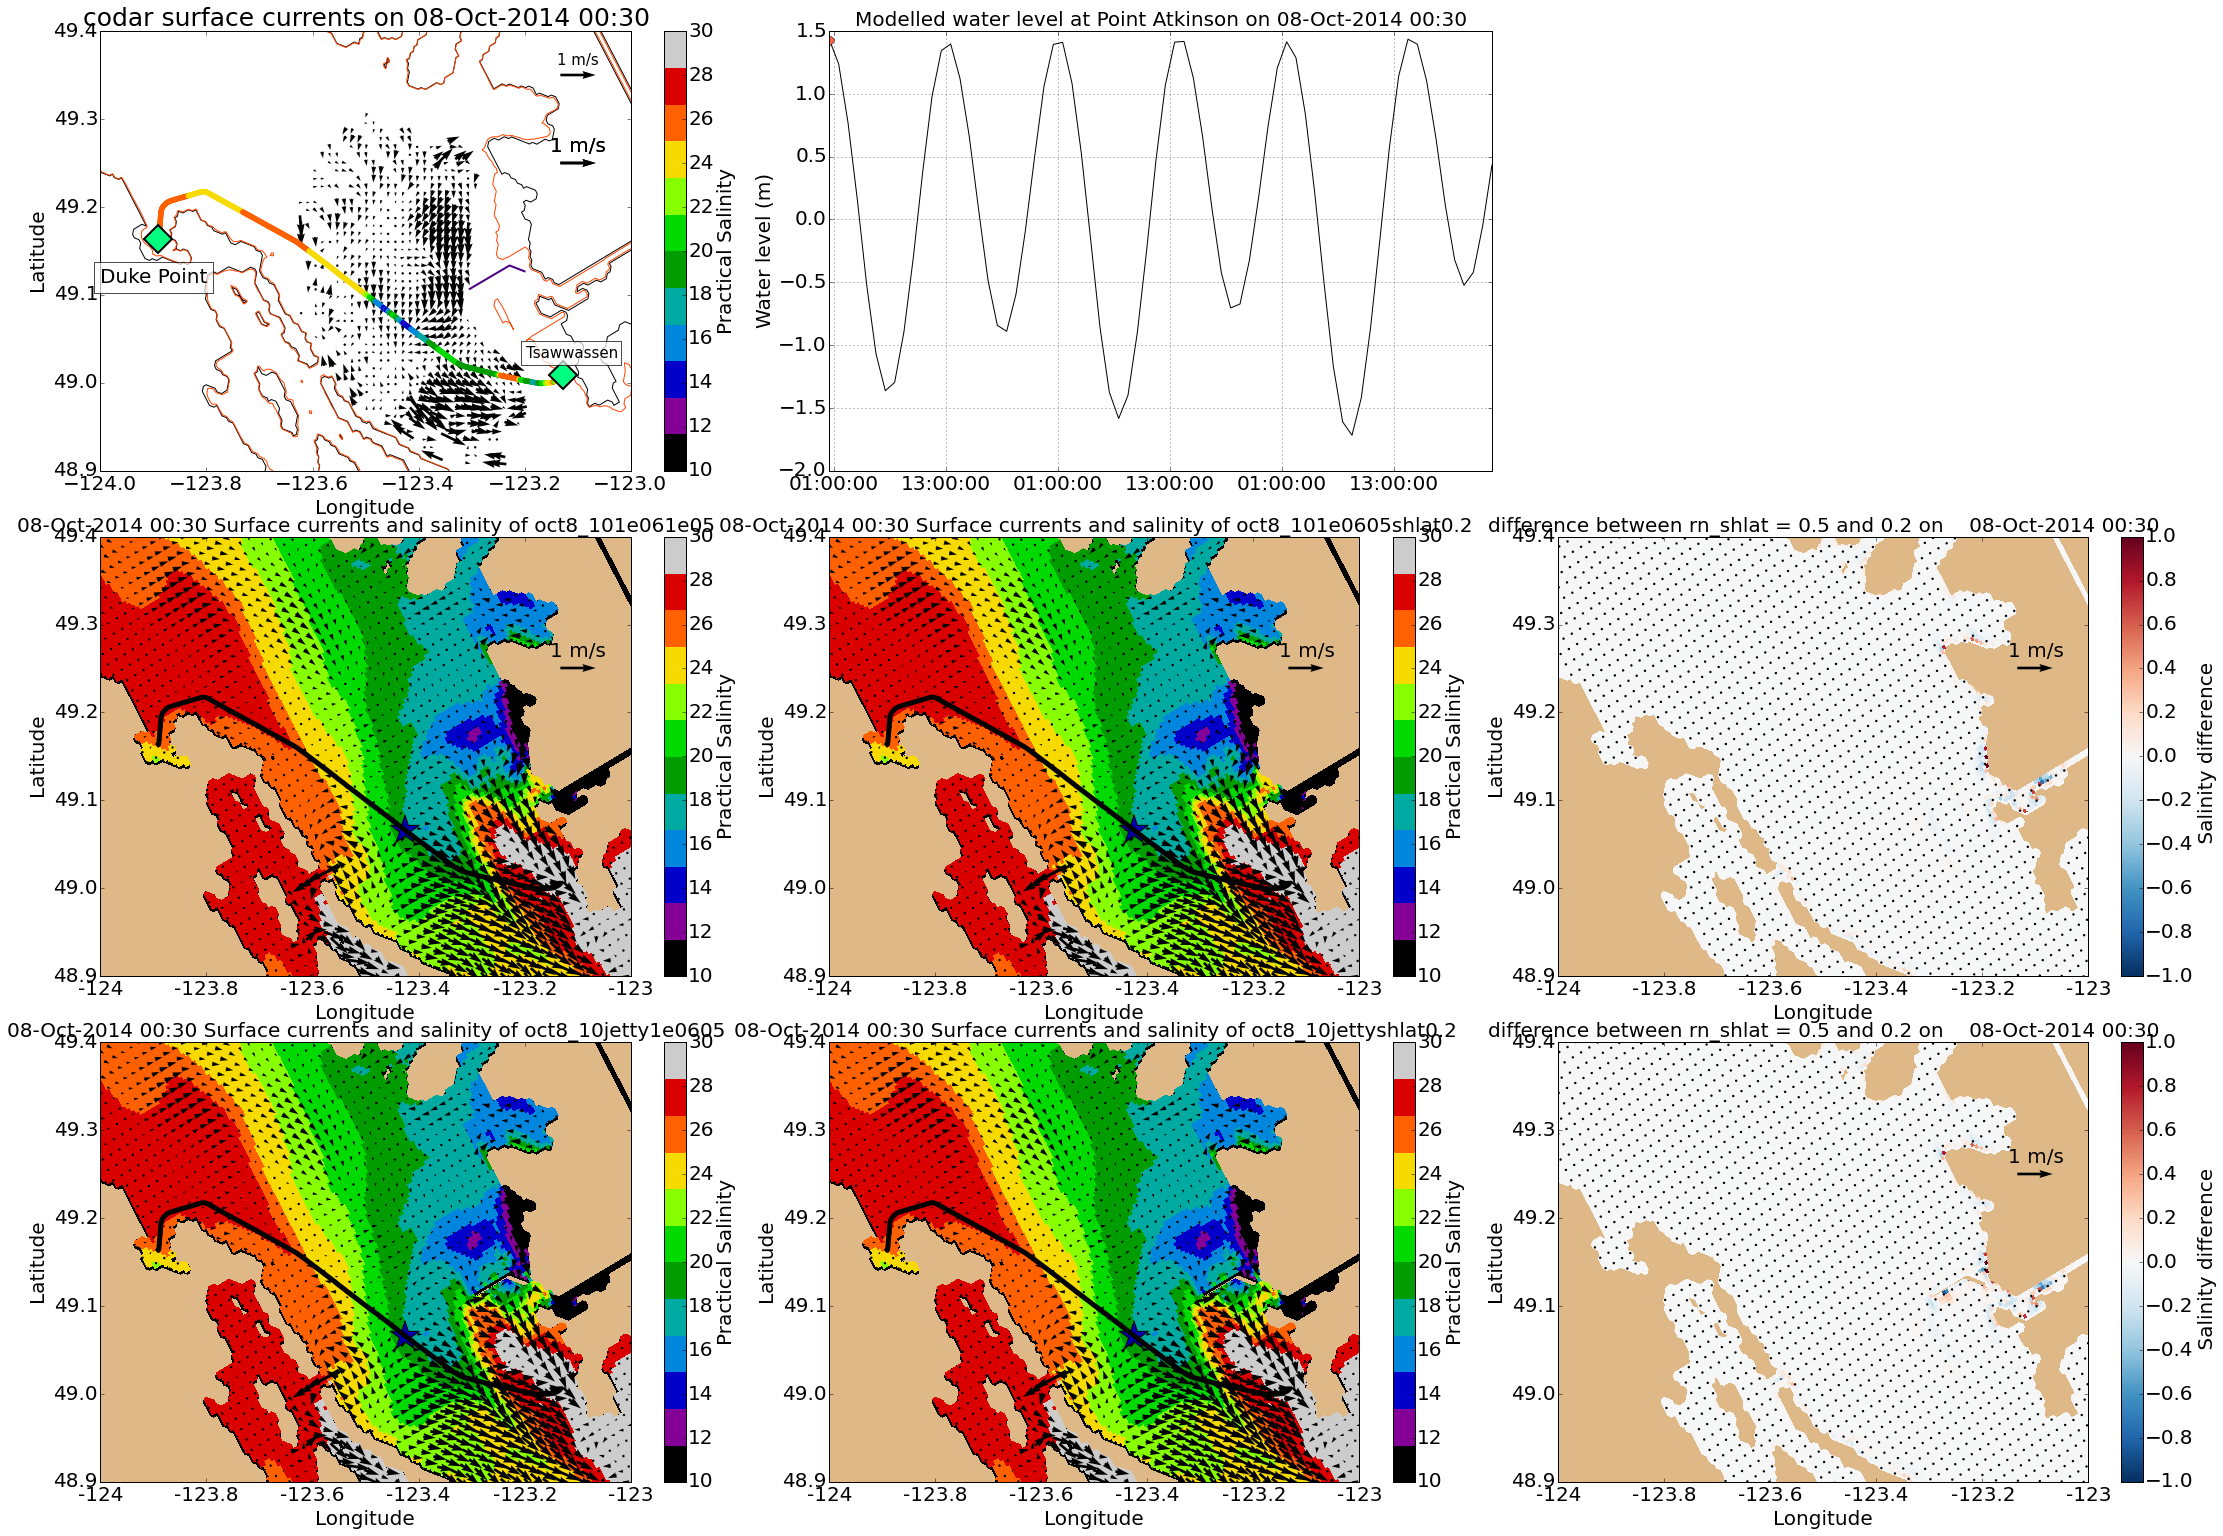

In [12]:
fig = plot_whole(run_time)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


M2 tidal phase at PA is: 71.85714285714286 degree


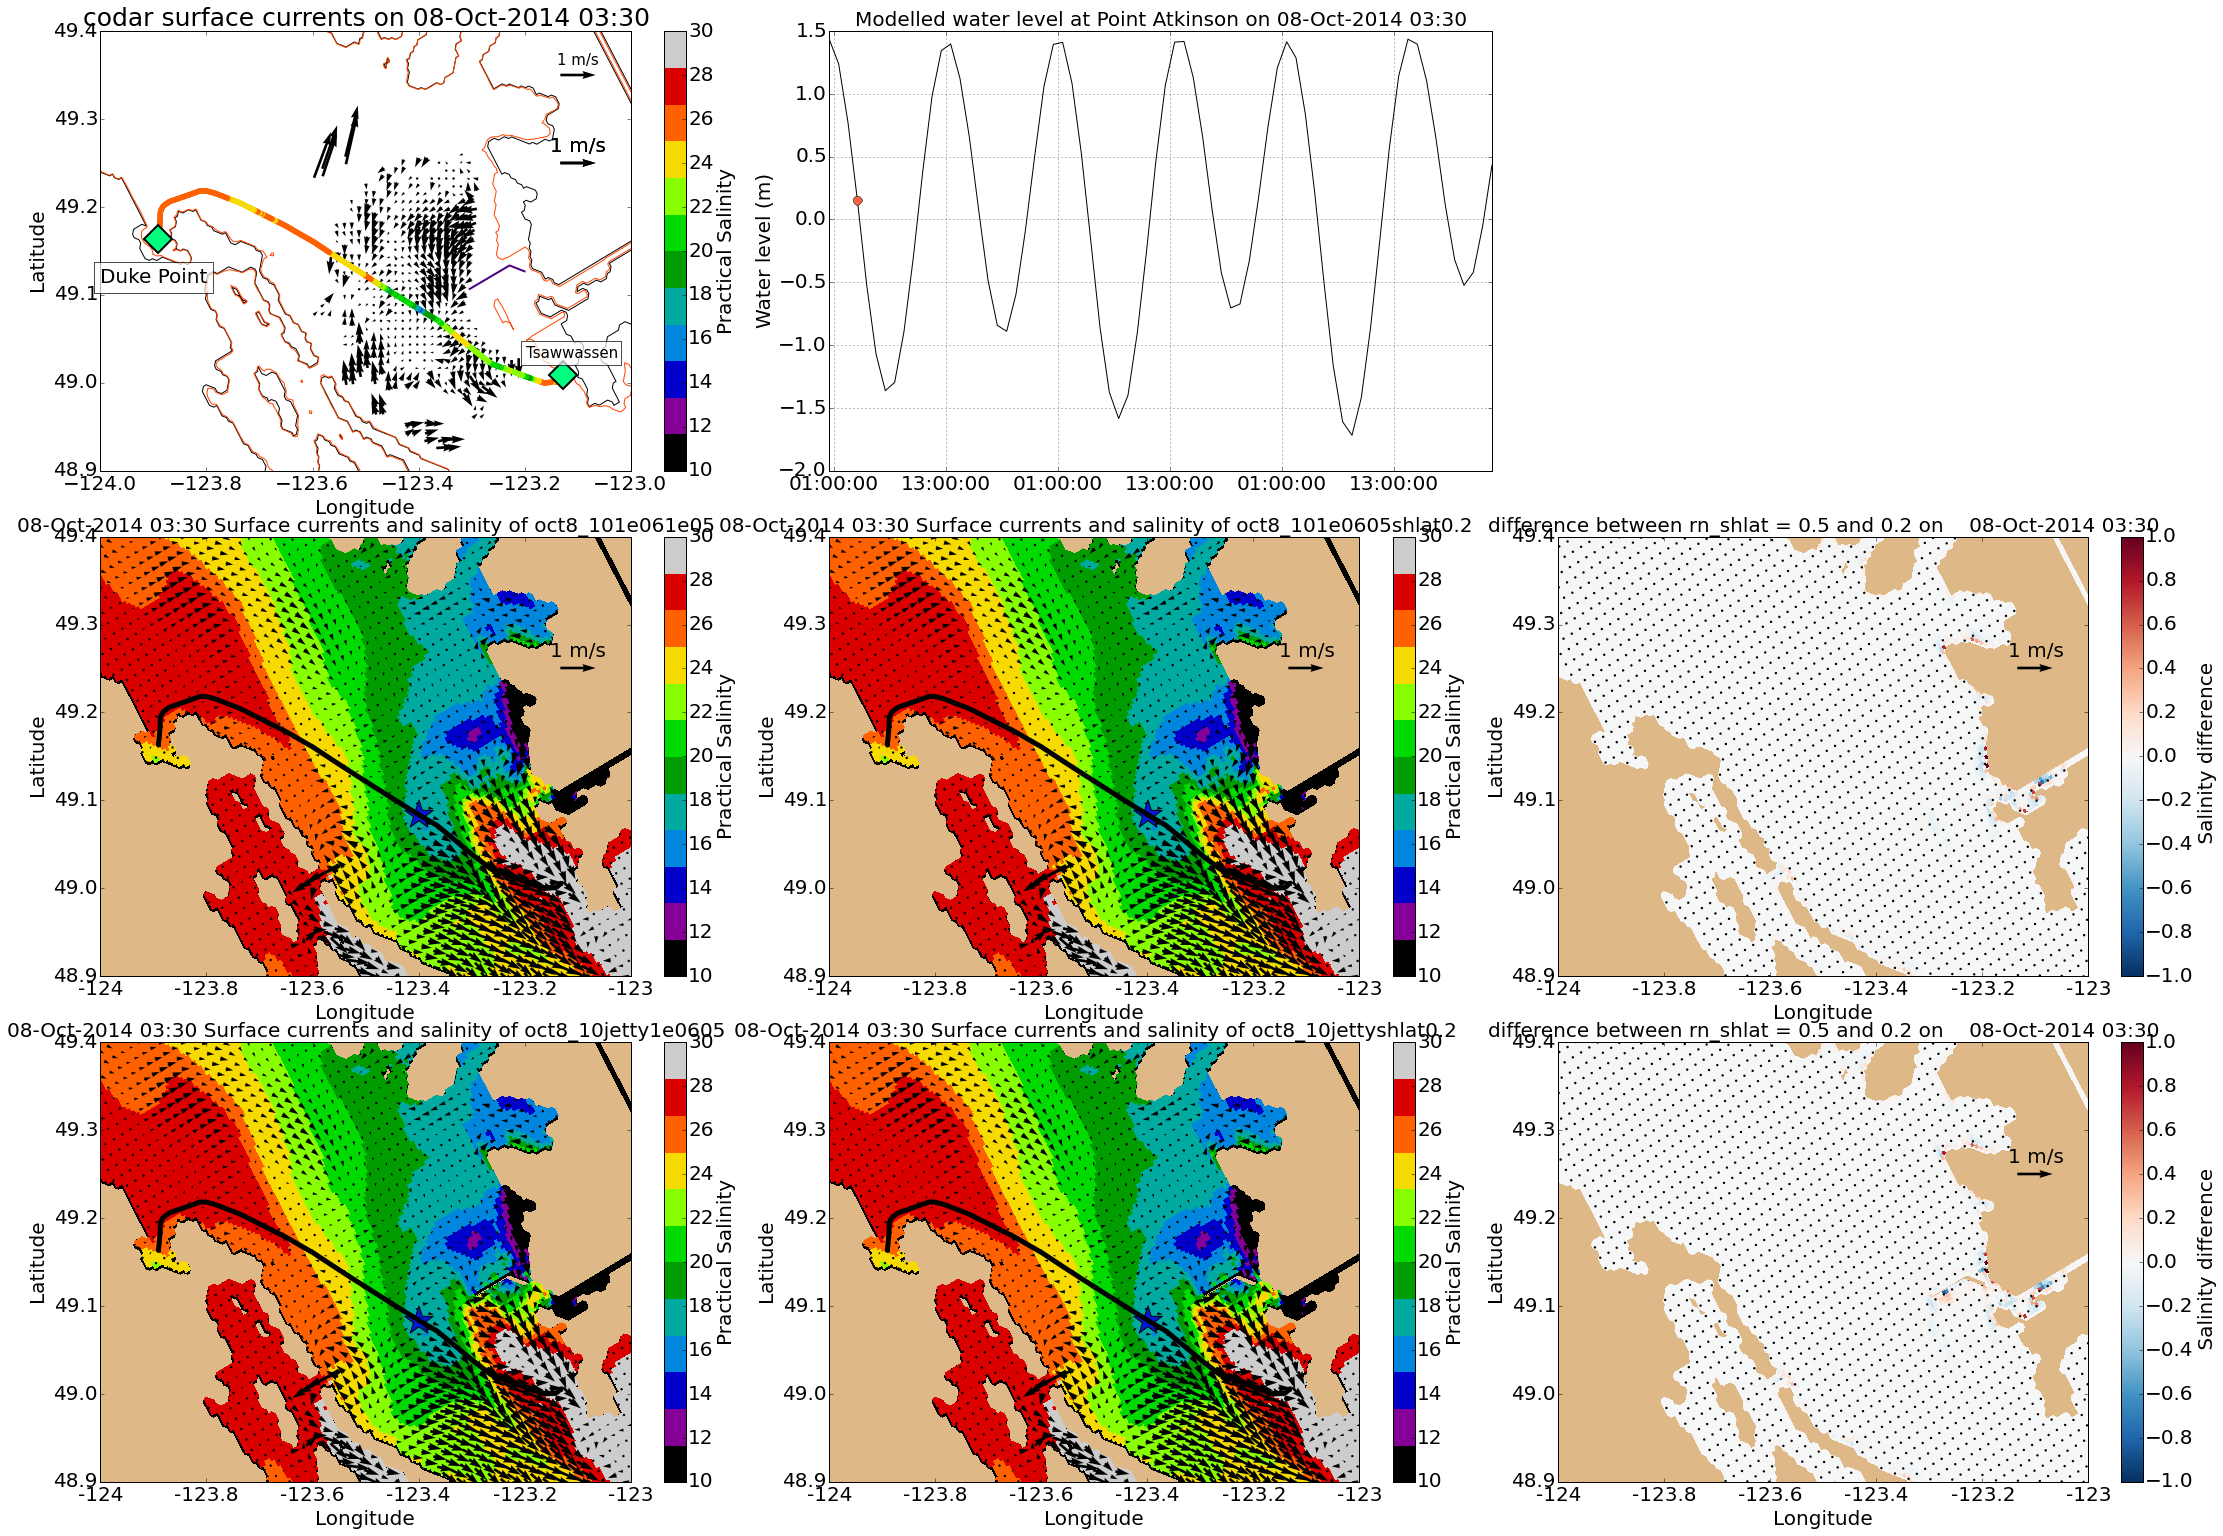

In [13]:
run_time = run_time.replace(hour = 3)
fig = plot_whole(run_time)

# Oct10

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


M2 tidal phase at PA is: 130.6326530612245 degree


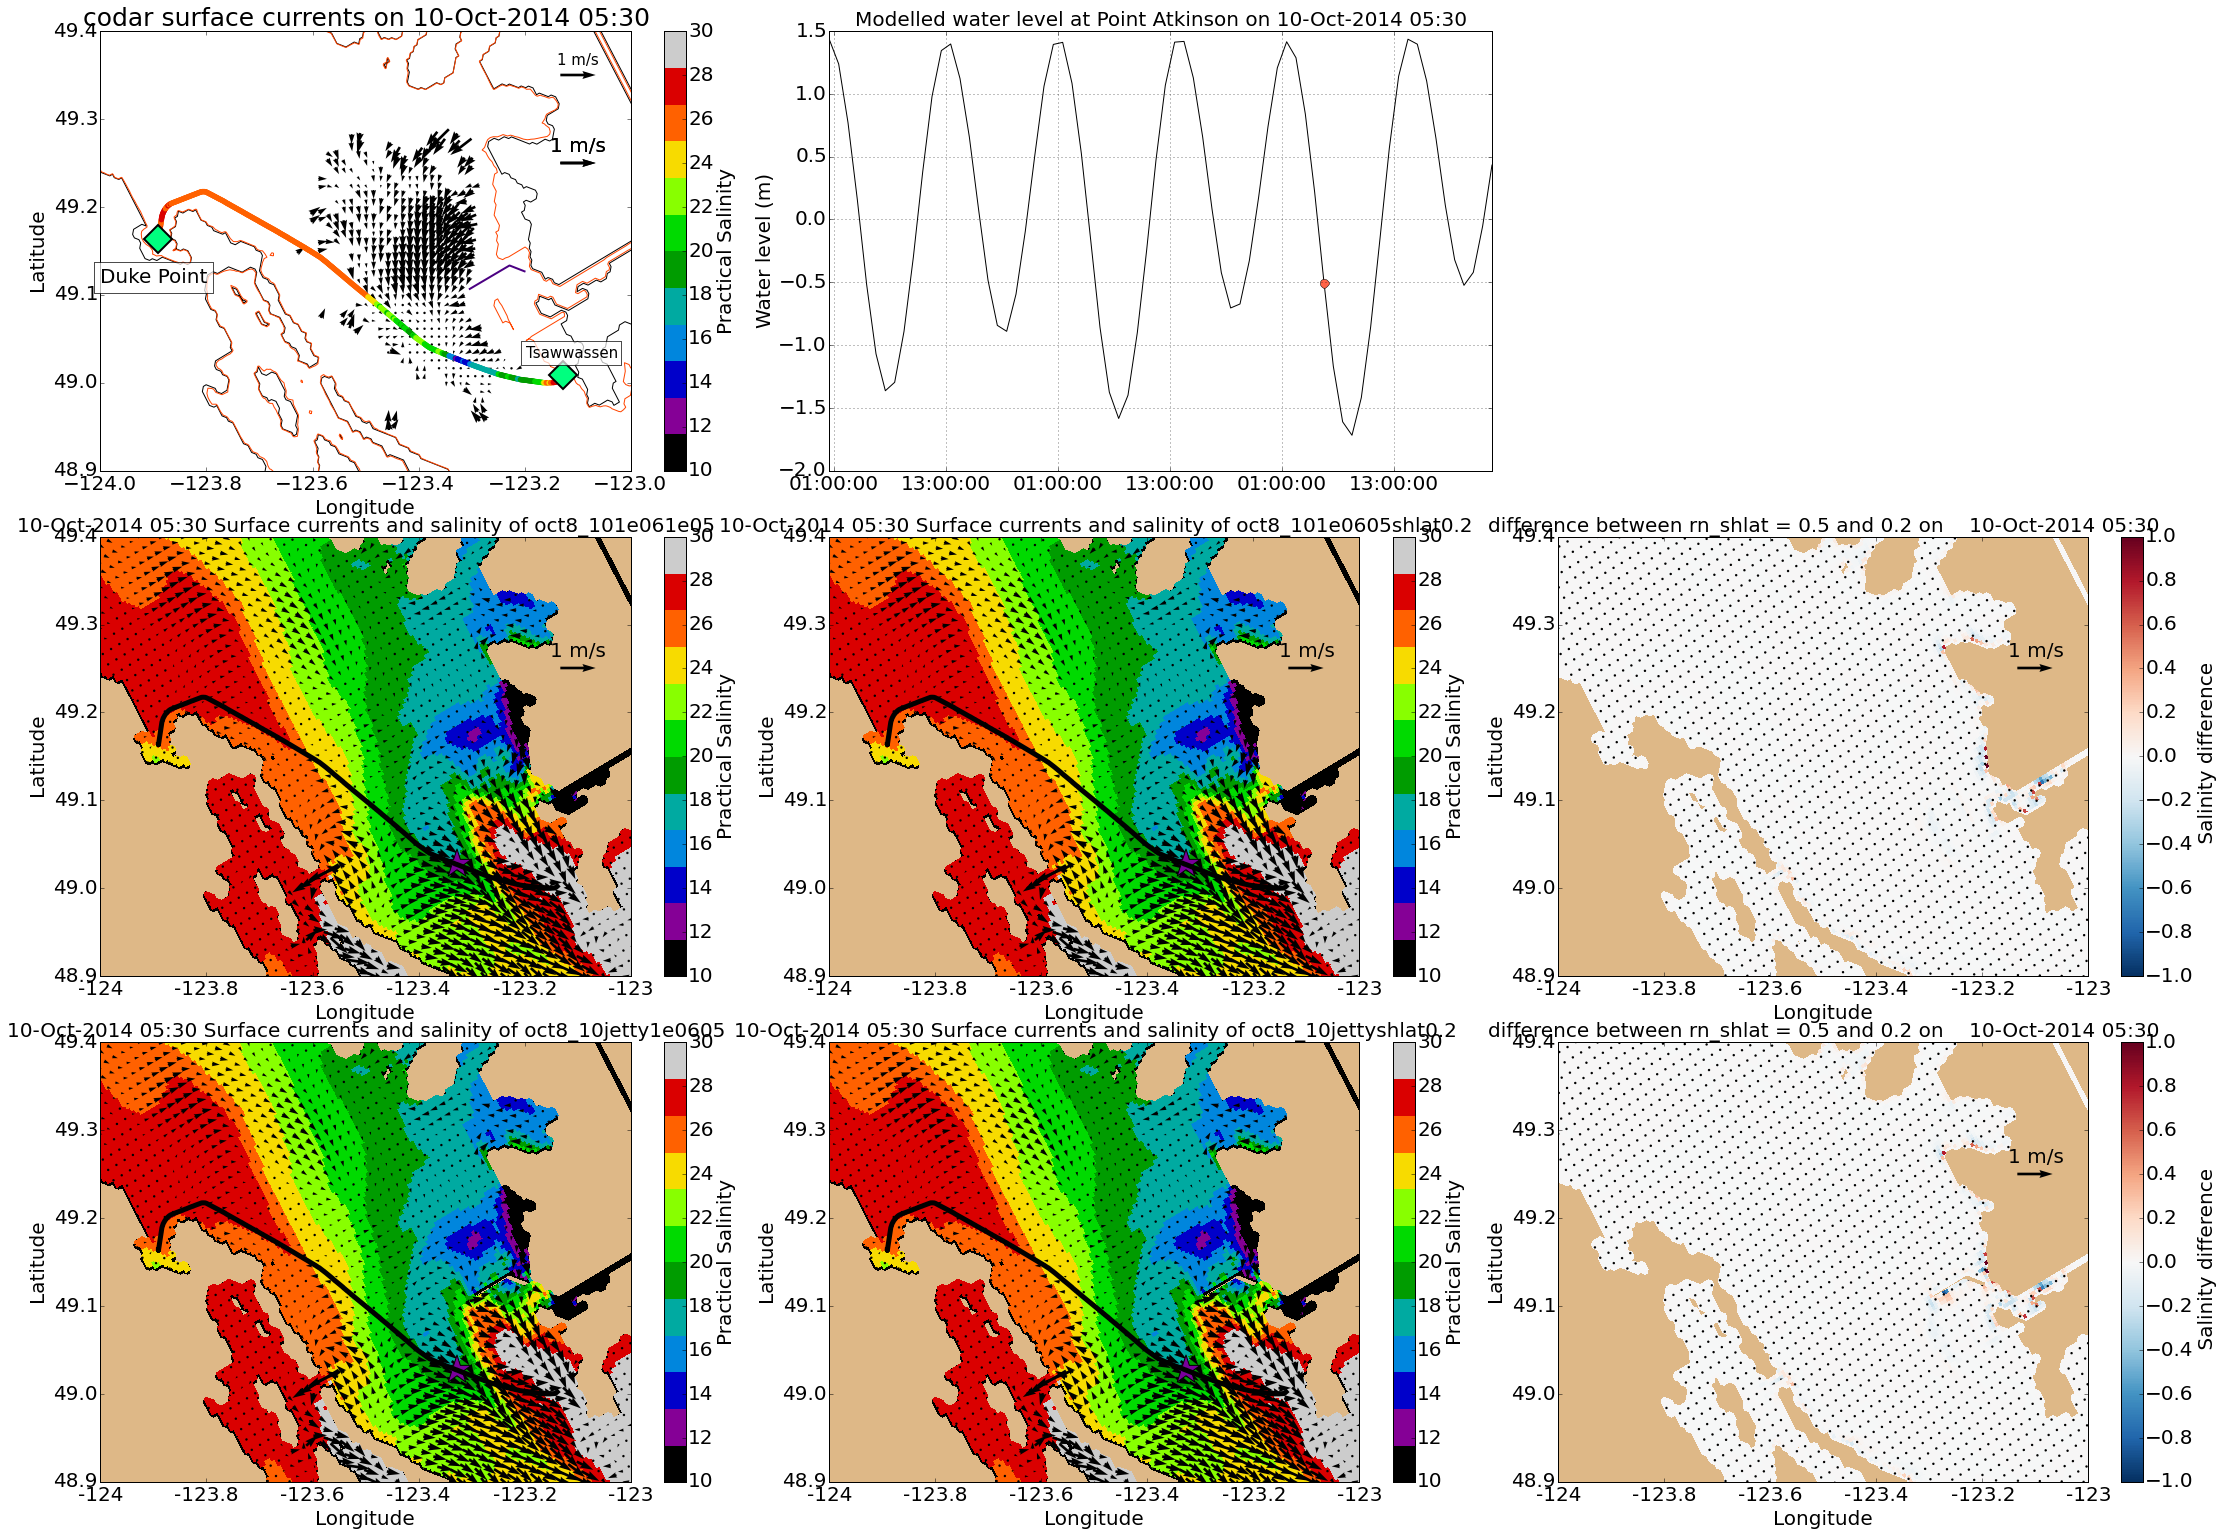

In [14]:
run_time = datetime.datetime(2014, 10, 10, 5)
fig = plot_whole(run_time)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


M2 tidal phase at PA is: 299.61224489795916 degree


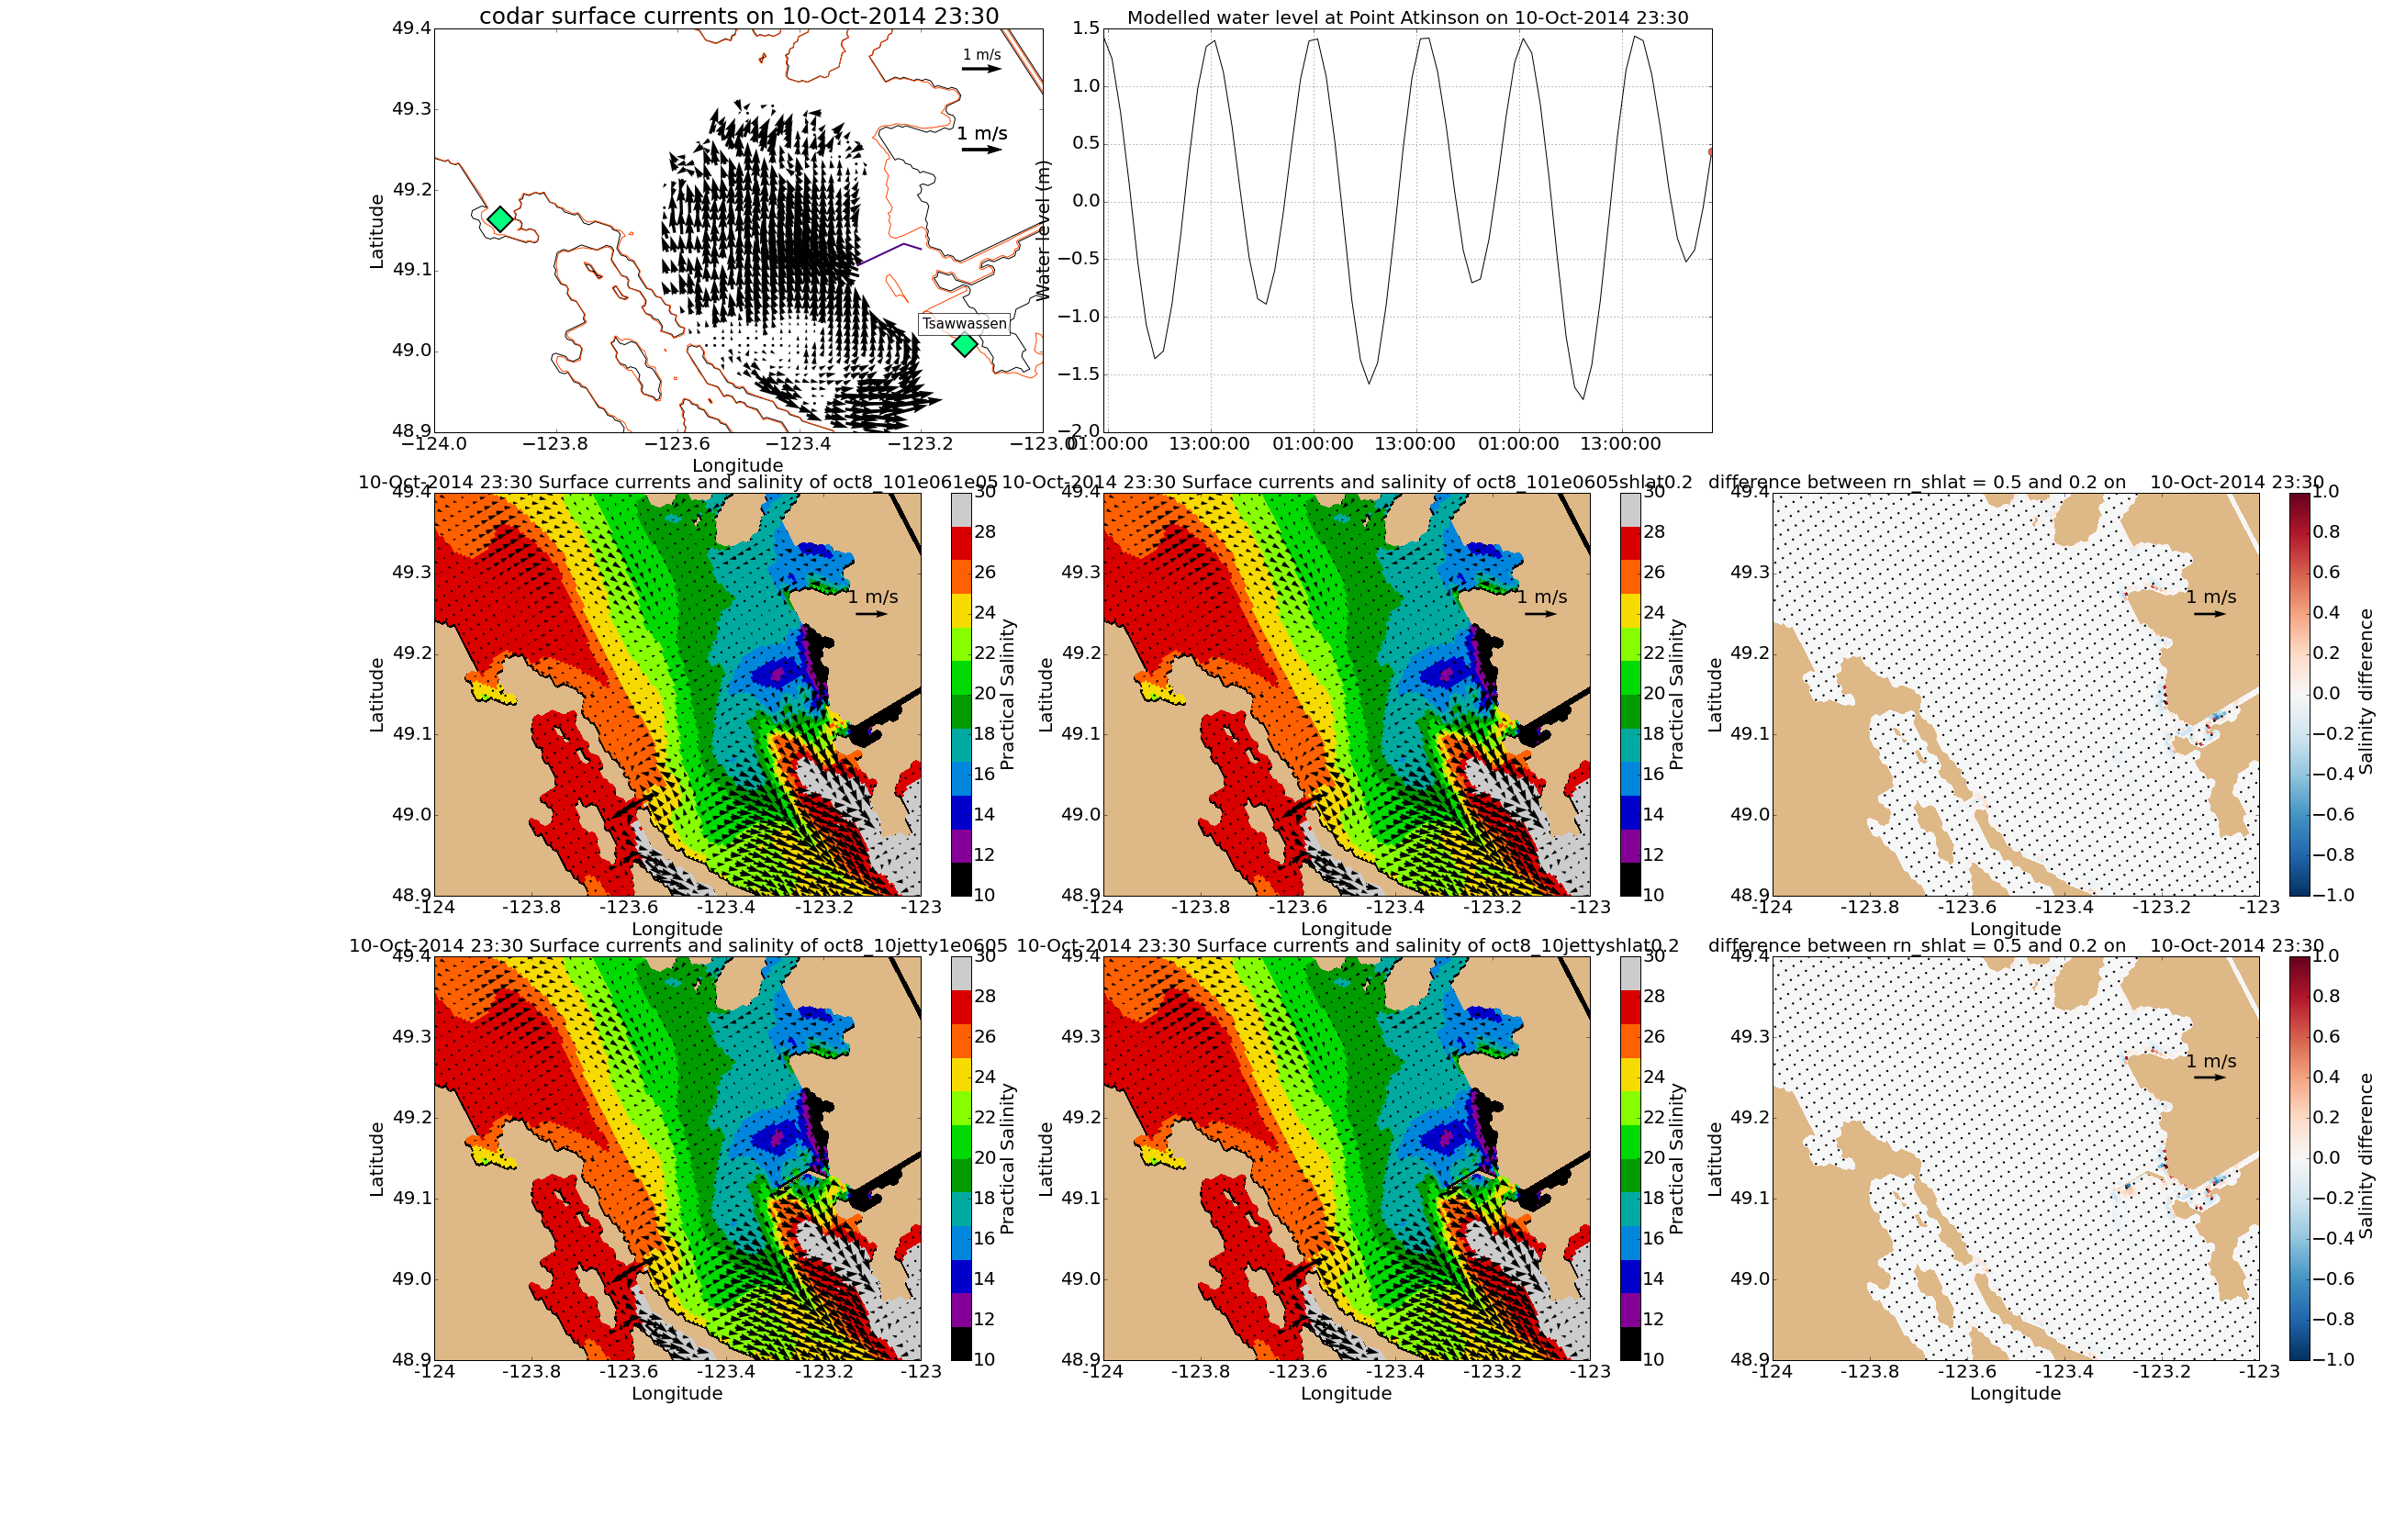

In [15]:
run_time = datetime.datetime(2014, 10, 10, 23)
fig = plot_whole(run_time)